# Problem Statement Health Insurance Lead Prediction

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

    Demographics (city, age, region etc.)
    Information regarding holding policies of the customer
    Recommended Policy Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import roc_auc_score

sns.set()
pd.options.display.max_columns = 100

In [2]:
raw_data = pd.read_csv("train_Df64byy.csv")
raw_data.shape

(50882, 14)

In [3]:
# split train and validation
train, valid = train_test_split(raw_data, test_size=0.33, random_state=42,stratify=raw_data['Response'])
train = train.copy()
valid = valid.copy()
print(f"Train Shape {train.shape}")
print(f"Valid Shape {valid.shape}")

Train Shape (34090, 14)
Valid Shape (16792, 14)


In [4]:
train.head(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
18517,18518,C19,2270,Owned,Individual,65,65,No,X5,9.0,3.0,2,19080.0,0
21636,21637,C7,1625,Owned,Individual,69,69,No,X2,2.0,4.0,15,14504.0,0
2743,2744,C33,912,Owned,Individual,52,52,No,NaN,12.0,3.0,8,17640.0,1


In [5]:
train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

In [6]:
object_type = ['ID','Region_Code','Holding_Policy_Type','Reco_Policy_Cat']
for col in object_type:
    train[col] = train[col].astype(np.object)    

In [7]:
train.describe(include=np.object).T

,count,unique,top,freq
ID,34090,34090,50882,1
City_Code,34090,36,C1,6079
Region_Code,34090,5029,1,62
Accomodation_Type,34090,2,Owned,18729
Reco_Insurance_Type,34090,2,Individual,27096
Is_Spouse,34090,2,No,28418
Health Indicator,26311,9,X1,8803
Holding_Policy_Duration,20500,15,1.0,3002
Holding_Policy_Type,20500,4,3,8867
Reco_Policy_Cat,34090,22,22,4402


In [8]:
train.describe()

,Upper_Age,Lower_Age,Reco_Policy_Premium,Response
count,34090.000000,34090.000000,34090.000000,34090.000000
mean,44.915342,42.770549,14215.008043,0.239953
std,17.323759,17.328425,6598.390147,0.427061
min,18.000000,16.000000,2280.000000,0.000000
25%,28.000000,27.000000,9248.000000,0.000000
50%,44.000000,40.000000,13216.000000,0.000000
75%,60.000000,57.000000,18172.000000,0.000000
max,75.000000,75.000000,43046.400000,1.000000


In [9]:
na_col = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
for col in na_col:
    train[col] = train[col].fillna('na')

In [10]:
train['Response'].value_counts(normalize=True)

0    0.760047
1    0.239953
Name: Response, dtype: float64

In [11]:
train['City_Code'].value_counts(normalize=True).cumsum()

C1     0.178322
C2     0.330625
C3     0.427750
C4     0.499619
C9     0.541625
C6     0.580141
C7     0.616280
C8     0.651951
C10    0.683045
C5     0.710414
C15    0.733236
C17    0.755940
C16    0.778351
C11    0.800645
C13    0.820006
C20    0.837430
C19    0.854825
C12    0.871135
C18    0.886800
C14    0.901936
C21    0.915635
C23    0.927134
C24    0.938105
C26    0.948313
C22    0.958404
C29    0.966500
C25    0.973951
C33    0.979818
C27    0.985685
C28    0.990701
C32    0.993928
C34    0.996597
C35    0.997741
C30    0.998827
C36    0.999648
C31    1.000000
Name: City_Code, dtype: float64

In [12]:
city_code = ['C1','C2','C3','C4','C9']
train['new_city_code'] =  train['City_Code'].apply(lambda x : x if x in city_code else 'other')
train['new_city_code'].value_counts(normalize=True)

other    0.458375
C1       0.178322
C2       0.152303
C3       0.097125
C4       0.071869
C9       0.042006
Name: new_city_code, dtype: float64

In [13]:
train['Region_Code'].nunique()

5029

In [14]:
train['age_gap'] = (train['Upper_Age'] == train['Lower_Age'])
train['age_gap'].value_counts(normalize=True)

True     0.794837
False    0.205163
Name: age_gap, dtype: float64

In [15]:
train['Health Indicator'].value_counts(normalize=True).cumsum()

X1    0.258228
na    0.486418
X2    0.687885
X3    0.822206
X4    0.935260
X5    0.968759
X6    0.993517
X7    0.997448
X8    0.998856
X9    1.000000
Name: Health Indicator, dtype: float64

In [16]:
health_ind = ['X1','na','X2','X3']
train['new_health_ind'] =  train['Health Indicator'].apply(lambda x : x if x in health_ind else 'other')
train['new_health_ind'].value_counts(normalize=True)

X1       0.258228
na       0.228190
X2       0.201467
other    0.177794
X3       0.134321
Name: new_health_ind, dtype: float64

In [17]:
train['Holding_Policy_Duration'].value_counts(normalize=True)

na      0.398651
1.0     0.088061
2.0     0.083896
14+     0.082752
3.0     0.070255
4.0     0.055001
5.0     0.046465
6.0     0.037489
7.0     0.032678
8.0     0.025902
9.0     0.022265
10.0    0.015987
11.0    0.010766
12.0    0.010560
13.0    0.010003
14.0    0.009270
Name: Holding_Policy_Duration, dtype: float64

In [18]:
train['policy_duration'] = train['Holding_Policy_Duration'].replace({'na':'0','14+':'14'}).astype(float)
train['policy_duration'].describe()

count    34090.000000
mean         3.603579
std          4.546766
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max         14.000000
Name: policy_duration, dtype: float64

In [19]:
train['Holding_Policy_Type'].value_counts(normalize=True)

na     0.398651
3.0    0.260106
1.0    0.159959
2.0    0.097917
4.0    0.083368
Name: Holding_Policy_Type, dtype: float64

In [20]:
train['Reco_Policy_Cat'].value_counts(normalize=True).cumsum()

22    0.129129
18    0.237694
21    0.336022
16    0.416603
17    0.491610
19    0.565679
20    0.627105
12    0.669757
1     0.708214
2     0.746377
14    0.780375
13    0.813259
15    0.844911
3     0.865415
5     0.885538
4     0.905104
6     0.921795
7     0.938252
11    0.954297
9     0.970226
10    0.985362
8     1.000000
Name: Reco_Policy_Cat, dtype: float64

In [21]:
recom_policy = [22,18,21,16,17,19,20]
train['new_reco_policy'] =  train['Reco_Policy_Cat'].apply(lambda x : str(x) if x in recom_policy else 'other')
train['new_reco_policy'].value_counts(normalize=True)

other    0.372895
22       0.129129
18       0.108566
21       0.098328
16       0.080581
17       0.075007
19       0.074069
20       0.061426
Name: new_reco_policy, dtype: float64

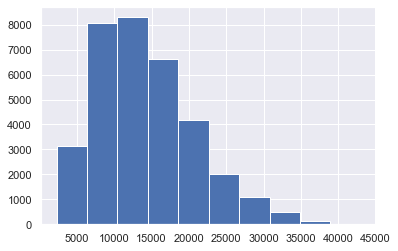

In [22]:
train['Reco_Policy_Premium'].hist()

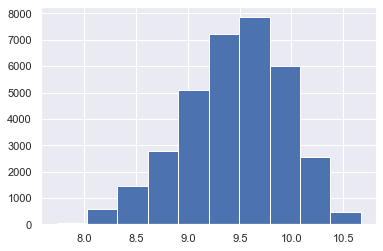

In [23]:
train['recom_prem'] = np.log(train['Reco_Policy_Premium'])
train['recom_prem'].hist()

In [24]:
train[train['new_city_code'] != 'other']['Region_Code'].value_counts(normalize=True).cumsum()

5       0.002925
4       0.005687
10      0.008178
7       0.010615
6       0.012944
          ...   
4958    0.999783
4869    0.999838
4883    0.999892
4892    0.999946
5932    1.000000
Name: Region_Code, Length: 2468, dtype: float64

In [25]:
train.sample(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_city_code,age_gap,new_health_ind,policy_duration,new_reco_policy,recom_prem
41843,41844,C6,1010,Rented,Individual,28,28,No,X2,na,na,13,8022.0,0,other,True,X2,0.0,other,8.989943
16142,16143,C2,3301,Rented,Individual,18,18,No,X3,na,na,12,7956.0,0,C2,True,X3,0.0,other,8.981682
13793,13794,C2,832,Rented,Individual,34,34,No,X2,13.0,3,22,10224.0,0,C2,True,X2,13.0,22,9.232493


In [26]:
train['Holding_Policy_Type'] = train['Holding_Policy_Type'].astype(str)

In [27]:
one_hot_cols = ['Accomodation_Type','Reco_Insurance_Type','Is_Spouse','new_city_code','new_health_ind',
               'new_reco_policy','Holding_Policy_Type','age_gap']

cat_encoder = OneHotEncoder(drop='first')
cat_array = cat_encoder.fit_transform(train[one_hot_cols])
one_hot = pd.DataFrame(cat_array.todense(),index=train.index,columns=cat_encoder.get_feature_names())


for idx, col in enumerate(one_hot_cols):
    one_hot.columns = one_hot.columns.str.replace(f"x{idx}",f"{col}")

one_hot.head(3)

,Accomodation_Type_Rented,Reco_Insurance_Type_Joint,Is_Spouse_Yes,new_city_code_C2,new_city_code_C3,new_city_code_C4,new_city_code_C9,new_city_code_other,new_health_ind_X2,new_health_ind_X3,new_health_ind_na,new_health_ind_other,new_reco_policy_17,new_reco_policy_18,new_reco_policy_19,new_reco_policy_20,new_reco_policy_21,new_reco_policy_22,new_reco_policy_other,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_True
18517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
21636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [28]:
num_col = ['Upper_Age','Lower_Age','policy_duration','recom_prem']
scaler = StandardScaler()
num_array = scaler.fit_transform(train[num_col])
num_df = pd.DataFrame(num_array,index=train.index,columns=num_col)
num_df.head(3)

,Upper_Age,Lower_Age,policy_duration,recom_prem
18517,1.159388,1.282850,1.186888,0.831886
21636,1.390288,1.513688,-0.352691,0.270871
2743,0.408962,0.532627,1.846707,0.671342


In [29]:
x_train = pd.concat([num_df,one_hot],axis=1,ignore_index=False,sort=False)
x_train.sample(2)

,Upper_Age,Lower_Age,policy_duration,recom_prem,Accomodation_Type_Rented,Reco_Insurance_Type_Joint,Is_Spouse_Yes,new_city_code_C2,new_city_code_C3,new_city_code_C4,new_city_code_C9,new_city_code_other,new_health_ind_X2,new_health_ind_X3,new_health_ind_na,new_health_ind_other,new_reco_policy_17,new_reco_policy_18,new_reco_policy_19,new_reco_policy_20,new_reco_policy_21,new_reco_policy_22,new_reco_policy_other,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_True
44867,0.120337,0.244080,2.286586,0.300003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
45506,1.101663,1.225141,-0.792570,1.200601,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [30]:
x_train.shape,train.shape

((34090, 28), (34090, 20))

In [31]:
def prep_data(data,cat_encoder,scaler):
    object_type = ['ID','Region_Code','Holding_Policy_Type','Reco_Policy_Cat']
    for col in object_type:
        data[col] = data[col].astype(np.object)  

    na_col = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
    for col in na_col:
        data[col] = data[col].fillna('na')

    city_code = ['C1','C2','C3','C4','C9']
    data['new_city_code'] =  data['City_Code'].apply(lambda x : x if x in city_code else 'other')

    data['age_gap'] = (data['Upper_Age'] == data['Lower_Age'])


    health_ind = ['X1','na','X2','X3']
    data['new_health_ind'] =  data['Health Indicator'].apply(lambda x : x if x in health_ind else 'other')

    data['policy_duration'] = data['Holding_Policy_Duration'].replace({'na':'0','14+':'14'}).astype(float)

    recom_policy = [22,18,21,16,17,19,20]
    data['new_reco_policy'] =  data['Reco_Policy_Cat'].apply(lambda x : str(x) if x in recom_policy else 'other')

    data['recom_prem'] = np.log(data['Reco_Policy_Premium'])

    data['Holding_Policy_Type'] = data['Holding_Policy_Type'].astype(str)

    one_hot_cols = ['Accomodation_Type','Reco_Insurance_Type','Is_Spouse','new_city_code','new_health_ind',
                   'new_reco_policy','Holding_Policy_Type','age_gap']

    cat_array = cat_encoder.transform(data[one_hot_cols])
    one_hot = pd.DataFrame(cat_array.todense(),index=data.index,columns=cat_encoder.get_feature_names())


    for idx, col in enumerate(one_hot_cols):
        one_hot.columns = one_hot.columns.str.replace(f"x{idx}",f"{col}")

    num_col = ['Upper_Age','Lower_Age','policy_duration','recom_prem']
    num_array = scaler.transform(data[num_col])
    num_df = pd.DataFrame(num_array,index=data.index,columns=num_col)

    x_data = pd.concat([num_df,one_hot],axis=1,ignore_index=False,sort=False)
    
    return x_data

In [32]:
x_valid = prep_data(valid,cat_encoder,scaler)
x_valid.head(3)

,Upper_Age,Lower_Age,policy_duration,recom_prem,Accomodation_Type_Rented,Reco_Insurance_Type_Joint,Is_Spouse_Yes,new_city_code_C2,new_city_code_C3,new_city_code_C4,new_city_code_C9,new_city_code_other,new_health_ind_X2,new_health_ind_X3,new_health_ind_na,new_health_ind_other,new_reco_policy_17,new_reco_policy_18,new_reco_policy_19,new_reco_policy_20,new_reco_policy_21,new_reco_policy_22,new_reco_policy_other,Holding_Policy_Type_2.0,Holding_Policy_Type_3.0,Holding_Policy_Type_4.0,Holding_Policy_Type_na,age_gap_True
26144,-0.860989,-0.736982,0.527068,-0.930094,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4755,-1.034164,-0.910110,-0.792570,-1.702586,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
45533,0.351237,0.474917,1.626767,-0.172158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [33]:
y_train = train['Response'].astype(int)
y_valid = valid['Response'].astype(int)

wgt = np.sum(y_train == 0)/np.sum(y_train==1)
wgt

3.167481662591687

In [34]:
def fit_model(models,x_train,y_train,x_valid,y_valid):
    for classifier in models:
        print(f"=========== Fitting {classifier} =====================")
        clf = models[classifier]
        clf.fit(x_train,y_train)
        train_auc =  roc_auc_score(y_train, clf.predict(x_train))
        valid_auc =  roc_auc_score(y_valid, clf.predict(x_valid))
        print(f"\tTrain AUC {train_auc}")
        print(f"\tValid AUC {valid_auc}")
    return

In [35]:
models = {
          "knn"            : KNeighborsClassifier(n_neighbors=5),
          "logisitc"       : LogisticRegression(class_weight='balanced',random_state=33),
          "linear svm"     : LinearSVC(class_weight='balanced',random_state=65,max_iter=300),
          "non linear svm" : SVC(gamma='auto',class_weight='balanced',random_state=98,kernel='poly',degree=2),
          "naive bayes"    : GaussianNB(),
          "random forest"  : RandomForestClassifier(random_state=0,n_estimators=100, max_depth=5),
          "ada bosst"      : AdaBoostClassifier(n_estimators=50,random_state=34),
          "gradient boost" : GradientBoostingClassifier(n_estimators=50,subsample=0.8,max_depth=5,random_state=89),
          "xgb boost"      : XGBClassifier(random_state=0, subsample=0.8,n_estimators=50, 
                                           max_depth=5,scale_pos_weight=wgt,eval_metric='auc'),
          "hist gradient"  : HistGradientBoostingClassifier(max_depth=5,random_state=43)
     }

In [36]:
# sample_x_train = x_train.head(350)
# sample_y_train = y_train.head(350).astype(int)
# sample_x_valid = x_valid.head(350)
# sample_y_valid = y_valid.head(350).astype(int)

# fit_model(models,sample_x_train,sample_y_train,sample_x_valid,sample_y_valid)

fit_model(models,x_train,y_train,x_valid,y_valid)

=========== Fitting knn =====================
	Train AUC 0.6191643964107465
	Valid AUC 0.5177831228179262
=========== Fitting logisitc =====================
	Train AUC 0.5532019337201655
	Valid AUC 0.55291237758407
=========== Fitting linear svm =====================


c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Train AUC 0.553214767310957
	Valid AUC 0.5531342859465926
=========== Fitting non linear svm =====================
	Train AUC 0.5651756739286546
	Valid AUC 0.5585707588486177
=========== Fitting naive bayes =====================
	Train AUC 0.5413636539497735
	Valid AUC 0.5411152673634056
=========== Fitting random forest =====================
	Train AUC 0.5
	Valid AUC 0.5
=========== Fitting ada bosst =====================
	Train AUC 0.5000611246943766
	Valid AUC 0.4999608242576197
=========== Fitting gradient boost =====================
	Train AUC 0.5041018185009423
	Valid AUC 0.5002616091706981
=========== Fitting xgb boost =====================
	Train AUC 0.6513919491865297
	Valid AUC 0.5563356412697593
=========== Fitting hist gradient =====================
	Train AUC 0.5028278958856074
	Valid AUC 0.5012672949137246


In [42]:
estimators = [("knn" ,KNeighborsClassifier(n_neighbors=5)),
              ( "logisitc",LogisticRegression(class_weight='balanced',random_state=33)),
              ("linear svm",LinearSVC(class_weight='balanced',random_state=65,max_iter=300)),
              ("non linear svm",SVC(gamma='auto',class_weight='balanced',random_state=98,kernel='poly',degree=2)),
              ("naive bayes" ,GaussianNB()),
              ("random forest",RandomForestClassifier(random_state=0,n_estimators=100, max_depth=5)),
              ("ada bosst" ,AdaBoostClassifier(n_estimators=50,random_state=34)),
              ("gradient boost" ,GradientBoostingClassifier(n_estimators=50,subsample=0.8,max_depth=5,random_state=89)),
              ("xgb boost" ,XGBClassifier(random_state=0, subsample=0.8,n_estimators=50, 
                                           max_depth=5,scale_pos_weight=wgt,eval_metric='auc')),
              ("hist gradient",HistGradientBoostingClassifier(max_depth=5,random_state=43))
             ]

In [43]:
final_est = LogisticRegression(class_weight='balanced',random_state=33)
clf = StackingClassifier(estimators=estimators, final_estimator=final_est,cv=3)
clf.fit(x_train,y_train)

c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHE

StackingClassifier(cv=3,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('logisitc',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=33)),
                               ('linear svm',
                                LinearSVC(class_weight='balanced', max_iter=300,
                                          random_state=65)),
                               ('non linear svm',
                                SVC(class_weight='balanced', degree=2,
                                    gamma='auto', kernel='poly',
                                    random_state=98)),
                               ('naive bayes', GaussianNB()),
                               ('rand...
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                           

In [44]:
train_auc =  roc_auc_score(y_train, clf.predict(x_train))
valid_auc =  roc_auc_score(y_valid, clf.predict(x_valid))
print(f"\tTrain AUC {train_auc}")
print(f"\tValid AUC {valid_auc}")

	Train AUC 0.619314884417473
	Valid AUC 0.5712976147408293


In [45]:
test = pd.read_csv("test_YCcRUnU.csv")
x_test = prep_data(test,cat_encoder,scaler)
test['Response'] = clf.predict(x_test)
test[['ID','Response']].to_csv("submit_1.csv",index=False)